<h1><div align="center">Asynchronous Streaming, and Visual Profiling with CUDA C/C++</div></h1>

![CUDA](./images/CUDA_Logo.jpg)

The CUDA toolkit ships with the **Nsight Systems**, a powerful GUI application to support the development of accelerated CUDA applications. Nsight Systems generates a graphical timeline of an accelerated application, with detailed information about CUDA API calls, kernel execution, memory activity, and the use of **CUDA streams**.

In this lab, you will be using the Nsight Systems timeline to guide you in optimizing accelerated applications. Additionally, you will learn some intermediate CUDA programming techniques to support your work: **unmanaged memory allocation and migration**; **pinning**, or **page-locking** host memory; and **non-default concurrent CUDA streams**.

At the end of this lab, you will be presented with an assessment, to accelerate and optimize a simple n-body particle simulator, which will allow you to demonstrate the skills you have developed during this course. Those of you who are able to accelerate the simulator while maintaining its correctness, will be granted a certification as proof of your competency.

---
## Prerequisites

To get the most out of this lab you should already be able to:

- Write, compile, and run C/C++ programs that both call CPU functions and launch GPU kernels.
- Control parallel thread hierarchy using execution configuration.
- Refactor serial loops to execute their iterations in parallel on a GPU.
- Allocate and free CUDA Unified Memory.
- Understand the behavior of Unified Memory with regard to page faulting and data migrations.
- Use asynchronous memory prefetching to reduce page faults and data migrations.

## Objectives

By the time you complete this lab you will be able to:

- Use **Nsight Systems** to visually profile the timeline of GPU-accelerated CUDA applications.
- Use Nsight Systems to identify, and exploit, optimization opportunities in GPU-accelerated CUDA applications.
- Utilize CUDA streams for concurrent kernel execution in accelerated applications.
- (**Optional Advanced Content**) Use manual device memory allocation, including allocating pinned memory, in order to asynchronously transfer data in concurrent CUDA streams.

---
## Running Nsight Systems

For this interactive lab environment, we have set up a remote desktop you can access from your browser, where you will be able to launch and use Nsight Systems.

You will begin by creating a report file for an already-existing vector addition program, after which you will be walked through a series of steps to open this report file in Nsight Systems, and to make the visual experience nice.

### Generate Report File

[`01-vector-add.cu`](../edit/01-vector-add/01-vector-add.cu) (<-------- click on these links to source files to edit them in the browser) contains a working, accelerated, vector addition application. Use the code execution cell directly below (you can execute it, and any of the code execution cells in this lab by `CTRL` + clicking it) to compile and run it. You should see a message printed that indicates it was successful.

In [1]:
!nvcc -o vector-add-no-prefetch 01-vector-add/01-vector-add.cu -run

Success! All values calculated correctly.


Next, use `nsys profile --stats=true` to create a report file that you will be able to open in the Nsight Systems visual profiler. Here we use the `-o` flag to give the report file a memorable name:

In [2]:
!nsys profile --stats=true -o vector-add-no-prefetch-report ./vector-add-no-prefetch

Success! All values calculated correctly.
Processing events...
Saving temporary "/tmp/nsys-report-e999-3e22-0f87-53a1.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-e999-3e22-0f87-53a1.qdrep"
Exporting 9755 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-e999-3e22-0f87-53a1.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls    Average     Minimum    Maximum           Name         
 -------  ---------------  ---------  -----------  ---------  ---------  ---------------------
    72.5        392933582          3  130977860.7      23369  392822147  cudaMallocManaged    
    23.4        126780996          1  126780996.0  126780996  126780996  cudaDeviceSynchronize
     4.1         22128374          3    7376124.7    6628551    8846117  cudaFree             
     0.0            55492      

### Open the Remote Desktop

Run the next cell to generate a link to the remote desktop. Then, read the instructions that follow in the notebook.

In [3]:
%%js
var port = ((window.location.port == 80) ? "" : (":"+window.location.port));
var url = 'http://' + window.location.hostname + port + '/nsight/vnc.html?resize=scale';
let a = document.createElement('a');
a.setAttribute('href', url)
a.setAttribute('target', '_blank')
a.innerText = 'Click to open remote desktop'
element.append(a);

<IPython.core.display.Javascript object>

After clicking the _Connect_ button you will be asked for a password, which is `nvidia`.

### Open Nsight Systems

To open Nsight Systems, double-click the "NVIDIA Nsight Systems" icon on the remote desktop.

![open nsight](images/open-nsight-sys.png)

### Enable Usage Reporting

When prompted, click "Yes" to enable usage reporting:

![enable usage](images/enable_usage.png)

### Select GPU Rows on Top

When prompted, select _GPU Rows on Top_ and then click _Okay_.

![gpu)_rows_on_top](images/gpu_on_top.png)

### Open the Report File

Open this report file by visiting _File_ -> _Open_ from the Nsight Systems menu and select `vector-add-no-prefetch-report.qdrep`:

![open-report](images/open-report.png)

### Ignore Warnings/Errors

You can close and ignore any warnings or errors you see, which are just a result of our particular remote desktop environment:

![ignore errors](images/ignore-error.png)

### Make More Room for the Timelines

To make your experience nicer, full-screen the profiler, close the _Project Explorer_ and hide the *Events View*:

![make nice](images/make-nice.png)

Your screen should now look like this:

![now nice](images/now-nice.png)

### Expand the CUDA Unified Memory Timelines

Next, expand the _CUDA_ -> _Unified memory_ and _Context_ timelines, and close the _Threads_ timelines:

![open memory](images/open-memory.png)

### Observe Many Memory Transfers

From a glance you can see that your application is taking about 1 second to run, and that also, during the time when the `addVectorsInto` kernel is running, that there is a lot of UM memory activity:

![memory and kernel](images/memory-and-kernel.png)

Zoom into the memory timelines to see more clearly all the small memory transfers being caused by the on-demand memory page faults. A couple tips:

1. You can zoom in and out at any point of the timeline by holding `CTRL` while scrolling your mouse/trackpad
2. You can zoom into any section by click + dragging a rectangle around it, and then selecting _Zoom in_

Here's an example of zooming in to see the many small memory transfers:

![many transfers](images/many-transfers.png)

---
## Comparing Code Refactors Iteratively with Nsight Systems

Now that you have Nsight Systems up and running and are comfortable moving around the timelines, you will be profiling a series of programs that were iteratively improved using techniques already familiar to you. Each time you profile, information in the timeline will give information supporting how you should next modify your code. Doing this will further increase your understanding of how various CUDA programming techniques affect application performance.

### Exercise: Compare the Timelines of Prefetching vs. Non-Prefetching

[`01-vector-add-prefetch-solution.cu`](../edit/01-vector-add/solutions/01-vector-add-prefetch-solution.cu) refactors the vector addition application from above so that the 3 vectors needed by its `addVectorsInto` kernel are asynchronously prefetched to the active GPU device prior to launching the kernel (using [`cudaMemPrefetchAsync`](http://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1ge8dc9199943d421bc8bc7f473df12e42)). Open the source code and identify where in the application these changes were made.

After reviewing the changes, compile and run the refactored application using the code execution cell directly below. You should see its success message printed.

In [4]:
!nvcc -o vector-add-prefetch 01-vector-add/solutions/01-vector-add-prefetch-solution.cu -run

Success! All values calculated correctly.


Now create a report file for this version of the application:

In [5]:
!nsys profile --stats=true -o vector-add-prefetch-report ./vector-add-prefetch

Success! All values calculated correctly.
Processing events...
Saving temporary "/tmp/nsys-report-e405-ee46-f5bf-c57b.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-e405-ee46-f5bf-c57b.qdrep"
Exporting 2134 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-e405-ee46-f5bf-c57b.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum    Maximum           Name         
 -------  ---------------  ---------  ----------  --------  ---------  ---------------------
    71.0        229513434          3  76504478.0     17502  229445633  cudaMallocManaged    
    16.9         54496434          1  54496434.0  54496434   54496434  cudaDeviceSynchronize
     7.5         24358942          3   8119647.3   6230718    9251342  cudaFree             
     4.6         14982805          3   49

Open the report in Nsight Systems, leaving the previous report open for comparison.

- How does the execution time compare to that of the `addVectorsInto` kernel prior to adding asynchronous prefetching?
- Locate `cudaMemPrefetchAsync` in the *CUDA API* section of the timeline.
- How have the memory transfers changed?

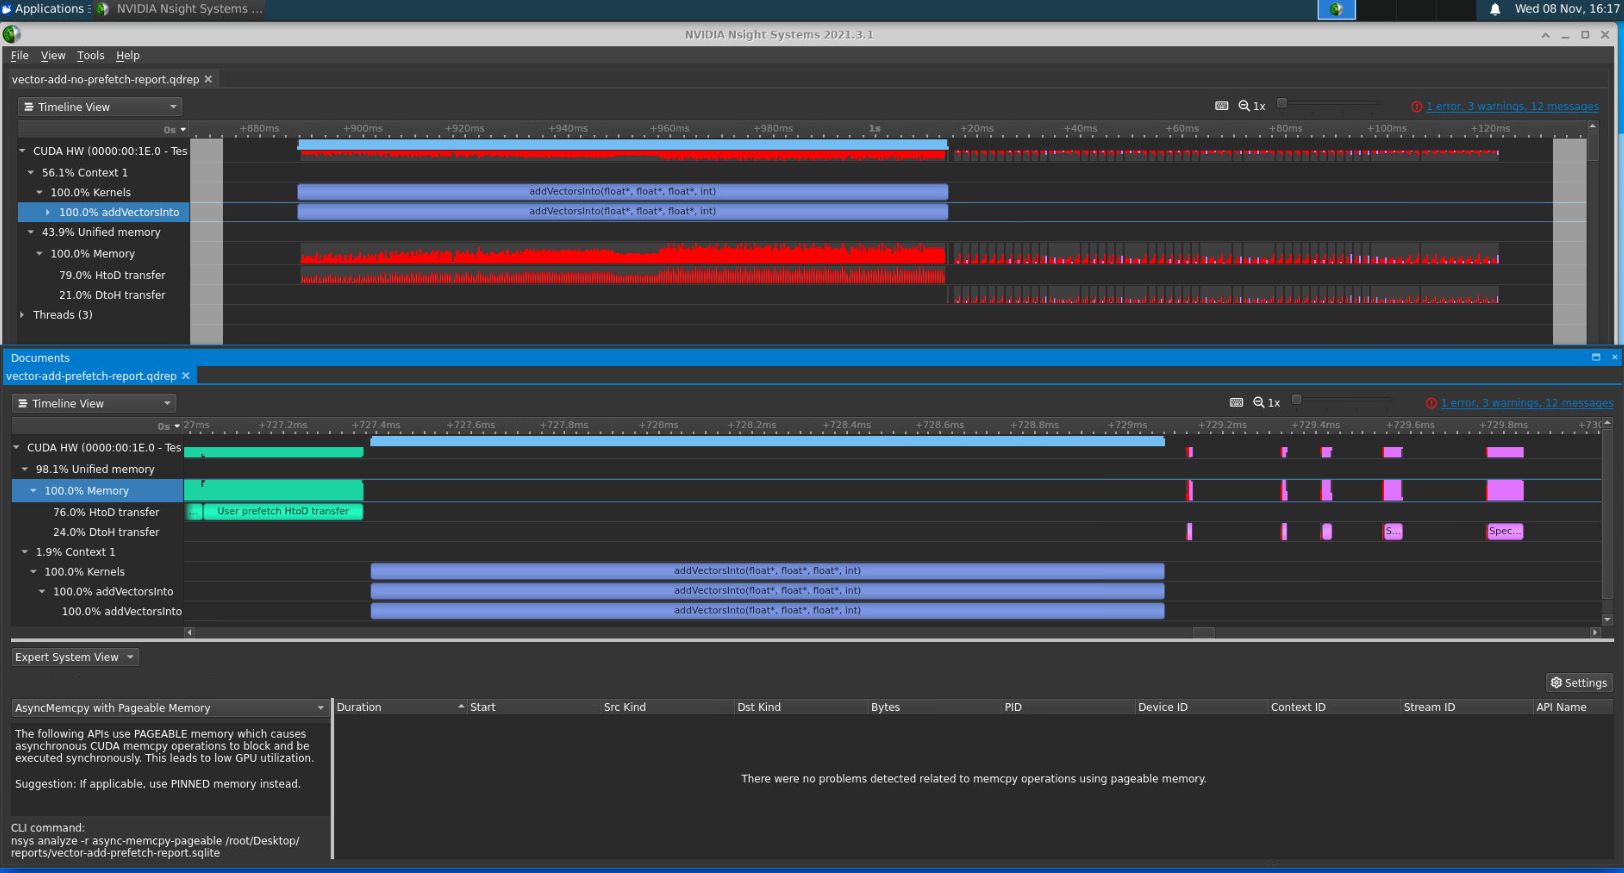
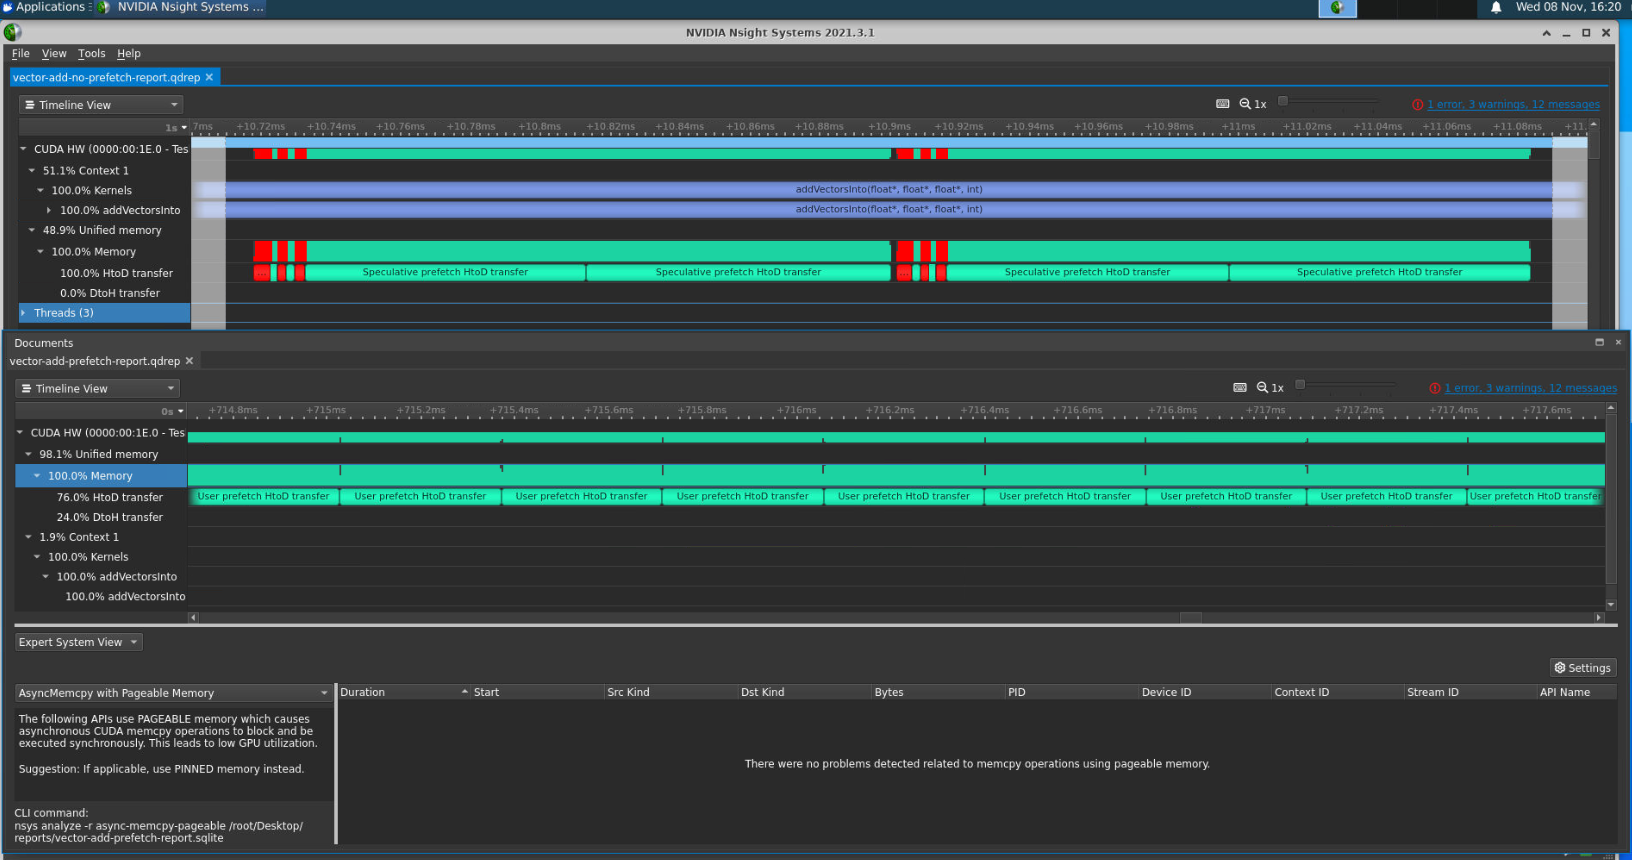

- Page faults are encountered if we run the kernel without memory prefetching;
- We get an improvement of about 10% on the execution time with prefetching;
- Memory transfers with prefetching are significantly faster than without prefetching.


### Exercise: Profile Refactor with Launch Init in Kernel

In the previous iteration of the vector addition application, the vector data is being initialized on the CPU, and therefore needs to be migrated to the GPU before the `addVectorsInto` kernel can operate on it.

The next iteration of the application, [01-init-kernel-solution.cu](../edit/02-init-kernel/solutions/01-init-kernel-solution.cu), the application has been refactored to initialize the data in parallel on the GPU.

Since the initialization now takes place on the GPU, prefetching has been done prior to initialization, rather than prior to the vector addition work. Review the source code to identify where these changes have been made.

After reviewing the changes, compile and run the refactored application using the code execution cell directly below. You should see its success message printed.

In [6]:
!nvcc -o init-kernel 02-init-kernel/solutions/01-init-kernel-solution.cu -run

Success! All values calculated correctly.


Now create a report file for this version of the application:

In [7]:
!nsys profile --stats=true -o init-kernel-report ./init-kernel

Success! All values calculated correctly.
Processing events...
Saving temporary "/tmp/nsys-report-22fa-16b0-168c-90a9.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-22fa-16b0-168c-90a9.qdrep"
Exporting 1879 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-22fa-16b0-168c-90a9.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum   Maximum           Name         
 -------  ---------------  ---------  ----------  -------  ---------  ---------------------
    89.6        235458185          3  78486061.7    18693  235364750  cudaMallocManaged    
     8.3         21758263          3   7252754.3   812075   19939596  cudaFree             
     1.4          3550321          1   3550321.0  3550321    3550321  cudaDeviceSynchronize
     0.8          2061828          3    687276

Open the new report file in Nsight Systems and do the following:

- Compare the application and `addVectorsInto` run times to the previous version of the application, how did they change?
- Look at the *Kernels* section of the timeline. Which of the two kernels (`addVectorsInto` and the initialization kernel) is taking up the majority of the time on the GPU?
- Which of the following does your application contain?
  - Data Migration (HtoD)
  - Data Migration (DtoH)
  
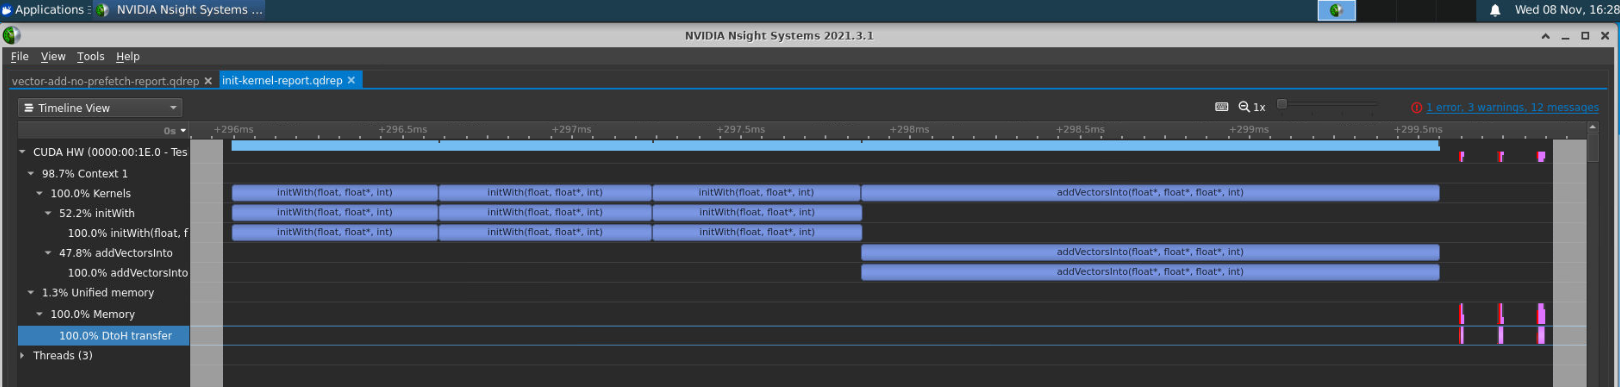


- The initialization of the kernel improved almost 100% (runtime is 320ms vs 600ms with only prefetching)
- As we can see in the image above, the initialization of the kernel is taking most of the time;
- Only Data Migration (DtoH).

### Exercise: Profile Refactor with Asynchronous Prefetch Back to the Host

Currently, the vector addition application verifies the work of the vector addition kernel on the host. The next refactor of the application, [01-prefetch-check-solution.cu](../edit/04-prefetch-check/solutions/01-prefetch-check-solution.cu), asynchronously prefetches the data back to the host for verification.

After reviewing the changes, compile and run the refactored application using the code execution cell directly below. You should see its success message printed.

In [8]:
!nvcc -o prefetch-to-host 04-prefetch-check/solutions/01-prefetch-check-solution.cu -run

Success! All values calculated correctly.


Now create a report file for this version of the application:

In [9]:
!nsys profile --stats=true -o prefetch-to-host-report ./prefetch-to-host

Success! All values calculated correctly.
Processing events...
Saving temporary "/tmp/nsys-report-b57c-3283-dc70-8659.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-b57c-3283-dc70-8659.qdrep"
Exporting 1181 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-b57c-3283-dc70-8659.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum   Maximum           Name         
 -------  ---------------  ---------  ----------  -------  ---------  ---------------------
    69.7        231357468          3  77119156.0    37858  231179722  cudaMallocManaged    
    25.6         85006417          4  21251604.3  1272249   80953300  cudaMemPrefetchAsync 
     3.6         11847932          3   3949310.7   794376   10063907  cudaFree             
     1.1          3533901          1   3533901

Open this report file in Nsight Systems, and do the following:

- Use the *Unified Memory* section of the timeline to compare and contrast the *Data Migration (DtoH)* events before and after adding prefetching back to the CPU.

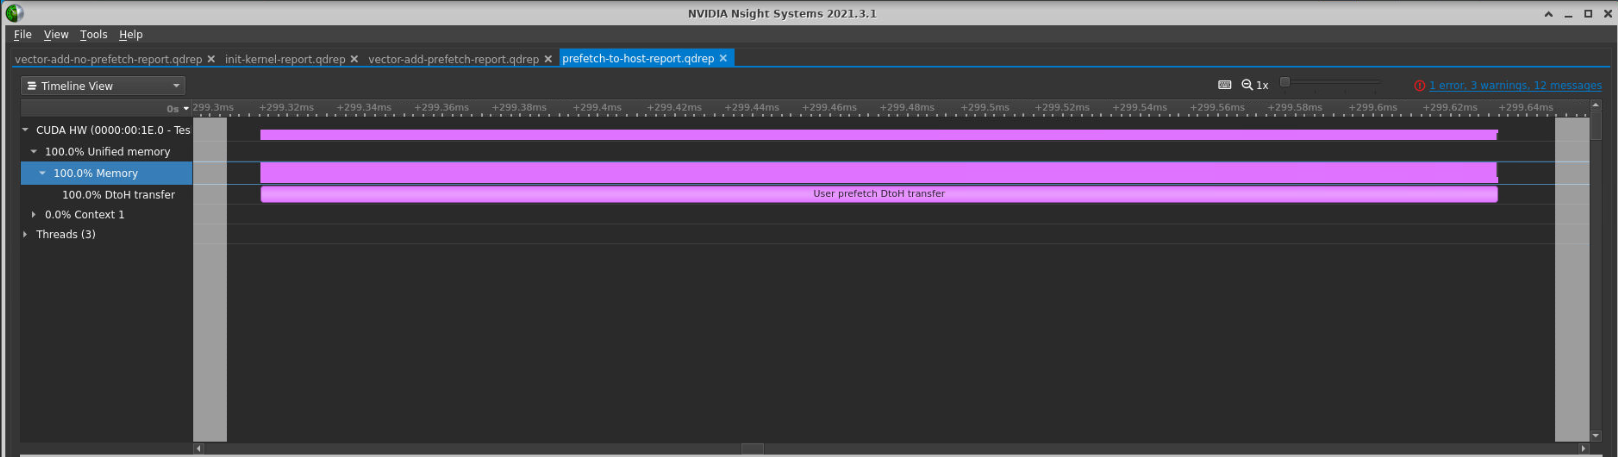

---
## Concurrent CUDA Streams

You are now going to learn about a new concept, **CUDA Streams**. After an introduction to them, you will return to using Nsight Systems to better evaluate their impact on your application's performance.

The following slides present upcoming material visually, at a high level. Click through the slides before moving on to more detailed coverage of their topics in following sections.

In [10]:
%%HTML

<div align="center"><iframe src="https://view.officeapps.live.com/op/view.aspx?src=https://developer.download.nvidia.com/training/courses/C-AC-01-V1/embedded/task3/NVVP-Streams-1.pptx" width="800px" height="500px" frameborder="0"></iframe></div>

In CUDA programming, a **stream** is a series of commands that execute in order. In CUDA applications, kernel execution, as well as some memory transfers, occur within CUDA streams. Up until this point in time, you have not been interacting explicitly with CUDA streams, but in fact, your CUDA code has been executing its kernels inside of a stream called *the default stream*.

CUDA programmers can create and utilize non-default CUDA streams in addition to the default stream, and in doing so, perform multiple operations, such as executing multiple kernels, concurrently, in different streams. Using multiple streams can add an additional layer of parallelization to your accelerated applications, and offers many more opportunities for application optimization.

### Rules Governing the Behavior of CUDA Streams

There are a few rules, concerning the behavior of CUDA streams, that should be learned in order to utilize them effectively:

- Operations within a given stream occur in order.
- Operations in different non-default streams are not guaranteed to operate in any specific order relative to each other.
- The default stream is blocking and will both wait for all other streams to complete before running, and, will block other streams from running until it completes.

### Creating, Utilizing, and Destroying Non-Default CUDA Streams

The following code snippet demonstrates how to create, utilize, and destroy a non-default CUDA stream. You will note, that to launch a CUDA kernel in a non-default CUDA stream, the stream must be passed as the optional 4th argument of the execution configuration. Up until now you have only utilized the first 2 arguments of the execution configuration:

```cpp
cudaStream_t stream;       // CUDA streams are of type `cudaStream_t`.
cudaStreamCreate(&stream); // Note that a pointer must be passed to `cudaCreateStream`.

someKernel<<<number_of_blocks, threads_per_block, 0, stream>>>(); // `stream` is passed as 4th EC argument.

cudaStreamDestroy(stream); // Note that a value, not a pointer, is passed to `cudaDestroyStream`.
```

Outside the scope of this lab, but worth mentioning, is the optional 3rd argument of the execution configuration. This argument allows programmers to supply the number of bytes in **shared memory** (an advanced topic that will not be covered presently) to be dynamically allocated per block for this kernel launch. The default number of bytes allocated to shared memory per block is `0`, and for the remainder of the lab, you will be passing `0` as this value, in order to expose the 4th argument, which is of immediate interest:

### Exercise: Predict Default Stream Behavior

The [01-print-numbers](../edit/05-stream-intro/01-print-numbers.cu) application has a very simple `printNumber` kernel which accepts an integer and prints it. The kernel is only being executed with a single thread inside a single block. However, it is being executed 5 times, using a for-loop, and passing each launch the number of the for-loop's iteration.

Compile and run [01-print-numbers](../edit/05-stream-intro/01-print-numbers.cu) using the code execution block below. You should see the numbers `0` through `4` printed.

In [11]:
!nvcc -o print-numbers 05-stream-intro/01-print-numbers.cu -run

0
1
2
3
4


Knowing that by default kernels are executed in the default stream, would you expect that the 5 launches of the `print-numbers` program executed serially, or in parallel? You should be able to mention two features of the default stream to support your answer. Create a report file in the cell below and open it in Nsight Systems to confirm your answer.

The 5 launches of the print-numbers program should be executed serially because the default stream will block other streams until it has finished its execution and it executes one instruction at the time.

In [12]:
!nsys profile --stats=true -o print-numbers-report ./print-numbers

0
1
2
3
4
Processing events...
Saving temporary "/tmp/nsys-report-b4bb-c586-44c7-836d.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-b4bb-c586-44c7-836d.qdrep"
Exporting 1023 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-b4bb-c586-44c7-836d.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum   Maximum           Name         
 -------  ---------------  ---------  ----------  -------  ---------  ---------------------
    99.9        204952036          5  40990407.2     3788  204932204  cudaLaunchKernel     
     0.1           274142          1    274142.0   274142     274142  cudaDeviceSynchronize



CUDA Kernel Statistics:

 Time(%)  Total Time (ns)  Instances  Average  Minimum  Maximum        Name      
 -------  ---------------  ---------  -------  -------  ----

### Exercise: Implement Concurrent CUDA Streams

Both because all 5 kernel launches occurred in the same stream, you should not be surprised to have seen that the 5 kernels executed serially. Additionally you could make the case that because the default stream is blocking, each launch of the kernel would wait to complete before the next launch, and this is also true.

Refactor [01-print-numbers](../edit/05-stream-intro/01-print-numbers.cu) so that each kernel launch occurs in its own non-default stream. Be sure to destroy the streams you create after they are no longer needed. Compile and run the refactored code with the code execution cell directly below. You should still see the numbers `0` through `4` printed, though not necessarily in ascending order.

In [13]:
!nvcc -o print-numbers-in-streams 05-stream-intro/01-print-numbers.cu -run

0
1
2
3
4


Now that you are using 5 different non-default streams for each of the 5 kernel launches, do you expect that they will run serially or in parallel? In addition to what you now know about streams, take into account how trivial the `printNumber` kernel is, meaning, even if you predict parallel runs, will the speed at which one kernel will complete allow for complete overlap?

After hypothesizing, open a new report file in Nsight Systems to view its actual behavior. You should notice that now, there are additional rows in the _CUDA_ section for each of the non-default streams you created:

In [14]:
!nsys profile --stats=true -o print-numbers-in-streams-report print-numbers-in-streams

0
1
2
3
4
Processing events...
Saving temporary "/tmp/nsys-report-ecc8-3725-3f46-3c4e.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-ecc8-3725-3f46-3c4e.qdrep"
Exporting 1048 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-ecc8-3725-3f46-3c4e.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum   Maximum           Name         
 -------  ---------------  ---------  ----------  -------  ---------  ---------------------
    99.9        215876991          5  43175398.2     2144  215867467  cudaStreamCreate     
     0.0            74998          1     74998.0    74998      74998  cudaDeviceSynchronize
     0.0            73709          5     14741.8     6598      44323  cudaLaunchKernel     
     0.0            19485          5      3897.0     2998       6890  cudaStre

![streams print](images/streams-print.png)

### Exercise: Use Streams for Concurrent Data Initialization Kernels

The vector addition application you have been working with, [01-prefetch-check-solution.cu](../edit/04-prefetch-check/solutions/01-prefetch-check-solution.cu), currently launches an initialization kernel 3 times - once each for each of the 3 vectors needing initialization for the `vectorAdd` kernel. Refactor it to launch each of the 3 initialization kernel launches in their own non-default stream. You should still see the success message print when compiling and running with the code execution cell below. Refer to [the solution](../edit/06-stream-init/solutions/01-stream-init-solution.cu) if you get stuck.

In [15]:
!nvcc -o init-in-streams 04-prefetch-check/solutions/01-prefetch-check-solution.cu -run

Success! All values calculated correctly.


Open a report in Nsight Systems to confirm that your 3 initialization kernel launches are running in their own non-default streams, with some degree of concurrent overlap.

In [16]:
!nsys profile --stats=true -o init-in-streams-report ./init-in-streams

Success! All values calculated correctly.
Processing events...
Saving temporary "/tmp/nsys-report-a768-8609-0a39-bf50.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-a768-8609-0a39-bf50.qdrep"
Exporting 1169 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-a768-8609-0a39-bf50.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls   Average    Minimum   Maximum           Name         
 -------  ---------------  ---------  ----------  -------  ---------  ---------------------
    78.1        224491241          3  74830413.7    16655  224412778  cudaMallocManaged    
    14.8         42545653          4  10636413.3   117083   41066895  cudaMemPrefetchAsync 
     5.2         15030431          3   5010143.7  1022478   12858772  cudaFree             
     1.8          5312675          1   5312675

---
## Summary

At this point in the lab you are able to:

- Use the **Nsight Systems** to visually profile the timeline of GPU-accelerated CUDA applications.
- Use Nsight Systems to identify, and exploit, optimization opportunities in GPU-accelerated CUDA applications.
- Utilize CUDA streams for concurrent kernel execution in accelerated applications.

At this point in time you have a wealth of fundamental tools and techniques for accelerating CPU-only applications, and for then optimizing those accelerated applications. In the final exercise, you will have a chance to apply everything that you've learned to accelerate an [n-body](https://en.wikipedia.org/wiki/N-body_problem) simulator, which predicts the individual motions of a group of objects interacting with each other gravitationally.

---
## Final Exercise: Accelerate and Optimize an N-Body Simulator

An [n-body](https://en.wikipedia.org/wiki/N-body_problem) simulator predicts the individual motions of a group of objects interacting with each other gravitationally. [01-nbody.cu](../edit/09-nbody/01-nbody.cu) contains a simple, though working, n-body simulator for bodies moving through 3 dimensional space.

In its current CPU-only form, this application takes about 5 seconds to run on 4096 particles, and **20 minutes** to run on 65536 particles. Your task is to GPU accelerate the program, retaining the correctness of the simulation.

### Considerations to Guide Your Work

Here are some things to consider before beginning your work:

- Especially for your first refactors, the logic of the application, the `bodyForce` function in particular, can and should remain largely unchanged: focus on accelerating it as easily as possible.
- The code base contains a for-loop inside `main` for integrating the interbody forces calculated by `bodyForce` into the positions of the bodies in the system. This integration both needs to occur after `bodyForce` runs, and, needs to complete before the next call to `bodyForce`. Keep this in mind when choosing how and where to parallelize.
- Use a **profile driven** and iterative approach.
- You are not required to add error handling to your code, but you might find it helpful, as you are responsible for your code working correctly.

**Have Fun!**

Use this cell to compile the nbody simulator. Although it is initially a CPU-only application, is does accurately simulate the positions of the particles.

In [17]:
!nvcc -std=c++11 -o nbody 09-nbody/01-nbody.cu

It is highly recommended you use the profiler to assist your work. Execute the following cell to generate a report file:

In [18]:
!nsys profile --stats=true --force-overwrite=true -o nbody-report ./nbody

4096 Bodies: average 16.120 Billion Interactions / second
Processing events...
Saving temporary "/tmp/nsys-report-fcb0-c40b-9e15-24f6.qdstrm" file to disk...

Creating final output files...
Processing [==============================================================100%]
Saved report file to "/tmp/nsys-report-fcb0-c40b-9e15-24f6.qdrep"
Exporting 1119 events: [==================================================100%]

Exported successfully to
/tmp/nsys-report-fcb0-c40b-9e15-24f6.sqlite


CUDA API Statistics:

 Time(%)  Total Time (ns)  Num Calls    Average     Minimum    Maximum           Name         
 -------  ---------------  ---------  -----------  ---------  ---------  ---------------------
    96.9        329968865          1  329968865.0  329968865  329968865  cudaMallocManaged    
     3.0         10243905         21     487805.0       1202    1340649  cudaDeviceSynchronize
     0.0           149147         20       7457.4       4040      42098  cudaLaunchKernel     
     0.0       

Here we import a function that will run your `nbody` simulator against a various number of particles, checking for performance and accuracy.

In [19]:
from assessment import run_assessment

Execute the following cell to run and assess `nbody`:

In [20]:
run_assessment()

Running nbody simulator with 4096 bodies
----------------------------------------

Application should run faster than 0.9s
Your application ran in: 0.2196s
Your application reports  4096 Bodies: average 16.188 Billion Interactions / second

Your results are correct

Running nbody simulator with 65536 bodies
----------------------------------------

Application should run faster than 1.3s
Your application ran in: 0.5134s
Your application reports  65536 Bodies: average 122.825 Billion Interactions / second

Your results are correct

Congratulations! You passed the assessment!
See instructions below to generate a certificate, and see if you can accelerate the simulator even more!


## Generate a Certificate

If you passed the assessment, please return to the course page (shown below) and click the "ASSESS TASK" button, which will generate your certificate for the course.

![run_assessment](./images/run_assessment.png)

## Advanced Content

The following sections, for those of you with time and interest, introduce more intermediate techniques involving some manual device memory management, and using non-default streams to overlap kernel execution and memory copies.

After learning about each of the techniques below, try to further optimize your nbody simulation using these techniques.

---
## Manual Device Memory Allocation and Copying

While `cudaMallocManaged` and `cudaMemPrefetchAsync` are performant, and greatly simplify memory migration, sometimes it can be worth it to use more manual methods for memory allocation. This is particularly true when it is known that data will only be accessed on the device or host, and the cost of migrating data can be reclaimed in exchange for the fact that no automatic on-demand migration is needed.

Additionally, using manual device memory management can allow for the use of non-default streams for overlapping data transfers with computational work. In this section you will learn some basic manual device memory allocation and copy techniques, before extending these techniques to overlap data copies with computational work. 

Here are some CUDA commands for manual device memory management:

- `cudaMalloc` will allocate memory directly to the active GPU. This prevents all GPU page faults. In exchange, the pointer it returns is not available for access by host code.
- `cudaMallocHost` will allocate memory directly to the CPU. It also "pins" the memory, or page locks it, which will allow for asynchronous copying of the memory to and from a GPU. Too much pinned memory can interfere with CPU performance, so use it only with intention. Pinned memory should be freed with `cudaFreeHost`.
- `cudaMemcpy` can copy (not transfer) memory, either from host to device or from device to host.

### Manual Device Memory Management Example

Here is a snippet of code that demonstrates the use of the above CUDA API calls.

```cpp
int *host_a, *device_a;        // Define host-specific and device-specific arrays.
cudaMalloc(&device_a, size);   // `device_a` is immediately available on the GPU.
cudaMallocHost(&host_a, size); // `host_a` is immediately available on CPU, and is page-locked, or pinned.

initializeOnHost(host_a, N);   // No CPU page faulting since memory is already allocated on the host.

// `cudaMemcpy` takes the destination, source, size, and a CUDA-provided variable for the direction of the copy.
cudaMemcpy(device_a, host_a, size, cudaMemcpyHostToDevice);

kernel<<<blocks, threads, 0, someStream>>>(device_a, N);

// `cudaMemcpy` can also copy data from device to host.
cudaMemcpy(host_a, device_a, size, cudaMemcpyDeviceToHost);

verifyOnHost(host_a, N);

cudaFree(device_a);
cudaFreeHost(host_a);          // Free pinned memory like this.
```

### Exercise: Manually Allocate Host and Device Memory

The most recent iteration of the vector addition application, [01-stream-init-solution](../edit/06-stream-init/solutions/01-stream-init-solution.cu), is using `cudaMallocManaged` to allocate managed memory first used on the device by the initialization kernels, then on the device by the vector add kernel, and then by the host, where the memory is automatically transferred, for verification. This is a sensible approach, but it is worth experimenting with some manual device memory allocation and copying to observe its impact on the application's performance.

Refactor the [01-stream-init-solution](../edit/06-stream-init/solutions/01-stream-init-solution.cu) application to **not** use `cudaMallocManaged`. In order to do this you will need to do the following:

- Replace calls to `cudaMallocManaged` with `cudaMalloc`.
- Create an additional vector that will be used for verification on the host. This is required since the memory allocated with `cudaMalloc` is not available to the host. Allocate this host vector with `cudaMallocHost`.
- After the `addVectorsInto` kernel completes, use `cudaMemcpy` to copy the vector with the addition results, into the host vector you created with `cudaMallocHost`.
- Use `cudaFreeHost` to free the memory allocated with `cudaMallocHost`.

Refer to [the solution](../edit/07-manual-malloc/solutions/01-manual-malloc-solution.cu) if you get stuck.

In [21]:
!nvcc -o vector-add-manual-alloc 06-stream-init/solutions/01-stream-init-solution.cu -run

Success! All values calculated correctly.


After completing the refactor, open a report in Nsight Systems, and use the timeline to do the following:

- Notice that there is no longer a *Unified Memory* section of the timeline.
- Comparing this timeline to that of the previous refactor, compare the run times of `cudaMalloc` in the current application vs. `cudaMallocManaged` in the previous.
- Notice how in the current application, work on the initialization kernels does not start until a later time than it did in the previous iteration. Examination of the timeline will show the difference is the time taken by `cudaMallocHost`. This clearly points out the difference between memory transfers, and memory copies. When copying memory, as you are doing presently, the data will exist in 2 different places in the system. In the current case, the allocation of the 4th host-only vector incurs a small cost in performance, compared to only allocating 3 vectors in the previous iteration.

---
## Using Streams to Overlap Data Transfers and Code Execution

The following slides present upcoming material visually, at a high level. Click through the slides before moving on to more detailed coverage of their topics in following sections.

In [22]:
%%HTML

<div align="center"><iframe src="https://view.officeapps.live.com/op/view.aspx?src=https://developer.download.nvidia.com/training/courses/C-AC-01-V1/embedded/task3/NVVP-Streams-3.pptx" width="800px" height="500px" frameborder="0"></iframe></div>

In addition to `cudaMemcpy` is `cudaMemcpyAsync` which can asynchronously copy memory either from host to device or from device to host as long as the host memory is pinned, which can be done by allocating it with `cudaMallocHost`.

Similar to kernel execution, `cudaMemcpyAsync` is only asynchronous by default with respect to the host. It executes, by default, in the default stream and therefore is a blocking operation with regard to other CUDA operations occurring on the GPU. The `cudaMemcpyAsync` function, however, takes as an optional 5th argument, a non-default stream. By passing it a non-default stream, the memory transfer can be concurrent to other CUDA operations occurring in other non-default streams.

A common and useful pattern is to use a combination of pinned host memory, asynchronous memory copies in non-default streams, and kernel executions in non-default streams, to overlap memory transfers with kernel execution.

In the following example, rather than wait for the entire memory copy to complete before beginning work on the kernel, segments of the required data are copied and worked on, with each copy/work segment running in its own non-default stream. Using this technique, work on parts of the data can begin while memory transfers for later segments occur concurrently. Extra care must be taken when using this technique to calculate segment-specific values for the number of operations, and the offset location inside arrays, as shown here:

```cpp
int N = 2<<24;
int size = N * sizeof(int);

int *host_array;
int *device_array;

cudaMallocHost(&host_array, size);               // Pinned host memory allocation.
cudaMalloc(&device_array, size);                 // Allocation directly on the active GPU device.

initializeData(host_array, N);                   // Assume this application needs to initialize on the host.

const int numberOfSegments = 4;                  // This example demonstrates slicing the work into 4 segments.
int segmentN = N / numberOfSegments;             // A value for a segment's worth of `N` is needed.
size_t segmentSize = size / numberOfSegments;    // A value for a segment's worth of `size` is needed.

// For each of the 4 segments...
for (int i = 0; i < numberOfSegments; ++i)
{
  // Calculate the index where this particular segment should operate within the larger arrays.
  segmentOffset = i * segmentN;

  // Create a stream for this segment's worth of copy and work.
  cudaStream_t stream;
  cudaStreamCreate(&stream);
  
  // Asynchronously copy segment's worth of pinned host memory to device over non-default stream.
  cudaMemcpyAsync(&device_array[segmentOffset],  // Take care to access correct location in array.
                  &host_array[segmentOffset],    // Take care to access correct location in array.
                  segmentSize,                   // Only copy a segment's worth of memory.
                  cudaMemcpyHostToDevice,
                  stream);                       // Provide optional argument for non-default stream.
                  
  // Execute segment's worth of work over same non-default stream as memory copy.
  kernel<<<number_of_blocks, threads_per_block, 0, stream>>>(&device_array[segmentOffset], segmentN);
  
  // `cudaStreamDestroy` will return immediately (is non-blocking), but will not actually destroy stream until
  // all stream operations are complete.
  cudaStreamDestroy(stream);
}
```

### Exercise: Overlap Kernel Execution and Memory Copy Back to Host

The most recent iteration of the vector addition application, [01-manual-malloc-solution.cu](../edit/07-manual-malloc/solutions/01-manual-malloc-solution.cu), is currently performing all of its vector addition work on the GPU before copying the memory back to the host for verification.

Refactor [01-manual-malloc-solution.cu](../edit/07-manual-malloc/solutions/01-manual-malloc-solution.cu) to perform the vector addition in 4 segments, in non-default streams, so that asynchronous memory copies can begin before waiting for all vector addition work to complete. Refer to [the solution](../edit/08-overlap-xfer/solutions/01-overlap-xfer-solution.cu) if you get stuck.

In [23]:
!nvcc -o vector-add-manual-alloc 07-manual-malloc/solutions/01-manual-malloc-solution.cu -run

Success! All values calculated correctly.


After completing the refactor, open a report in Nsight Systems, and use the timeline to do the following:

- Note when the device to host memory transfers begin, is it before or after all kernel work has completed?
- Notice that the 4 memory copy segments themselves do not overlap. Even in separate non-default streams, only one memory transfer in a given direction (DtoH here) at a time can occur simultaneously. The performance gains here are in the ability to start the transfers earlier than otherwise, and it is not hard to imagine in an application where a less trivial amount of work was being done compared to a simple addition operation, that the memory copies would not only start earlier, but also overlap with kernel execution.